In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)

## Infer Markov Chain transition matrix from political regime time-series data

In [2]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')

In [3]:
nCountries = len(timeSeries['country'].unique()) # numer of countries

In [4]:
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [5]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist'):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')["polity2"].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

def computeSteadyStateBruteForce(transitionMatrix,nSteps,initialCondition=0):
    # computes it the brutal way with iterating the transition
    
    n=transitionMatrix.shape[0] # number of Markov states
    
    if initialCondition==0:
        # if it is zero use a random vector
        x = np.random.rand(n)
        x = x / np.sum(x)
    else:
        # set it to the intial condition that we provided
        x= initialCondition
    # fo over each step
    for i in np.arange(nSteps):
        #x= P_allCountries.dot(x)
        x= x.dot(transitionMatrix)
    
    return(x)

def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


def simulateMarkovChain(transitionMatrix,initialCondition,nSteps=100):
    
    n=transitionMatrix.shape[0] # number of states
    
    stateVector=[initialCondition]
    for i in np.arange(nSteps):
        newstate = np.random.choice(np.arange(n), p=transitionMatrix[stateVector[i],:])
        stateVector.append(newstate)
    return(stateVector)
    

def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  


def createSimpleMarkovChain():
    
    P=np.zeros((2,2)) # empty transition matrix
    
    P[0,0] = 0.9
    P[0,1] = 0.1
    P[1,0] = 0.5
    P[1,1] = 0.5
    
    return(P)

# Analyse the actual data
## Frequentist approach 

In [6]:
P_allCountries = estimateTransitionMatrix(timeSeries)


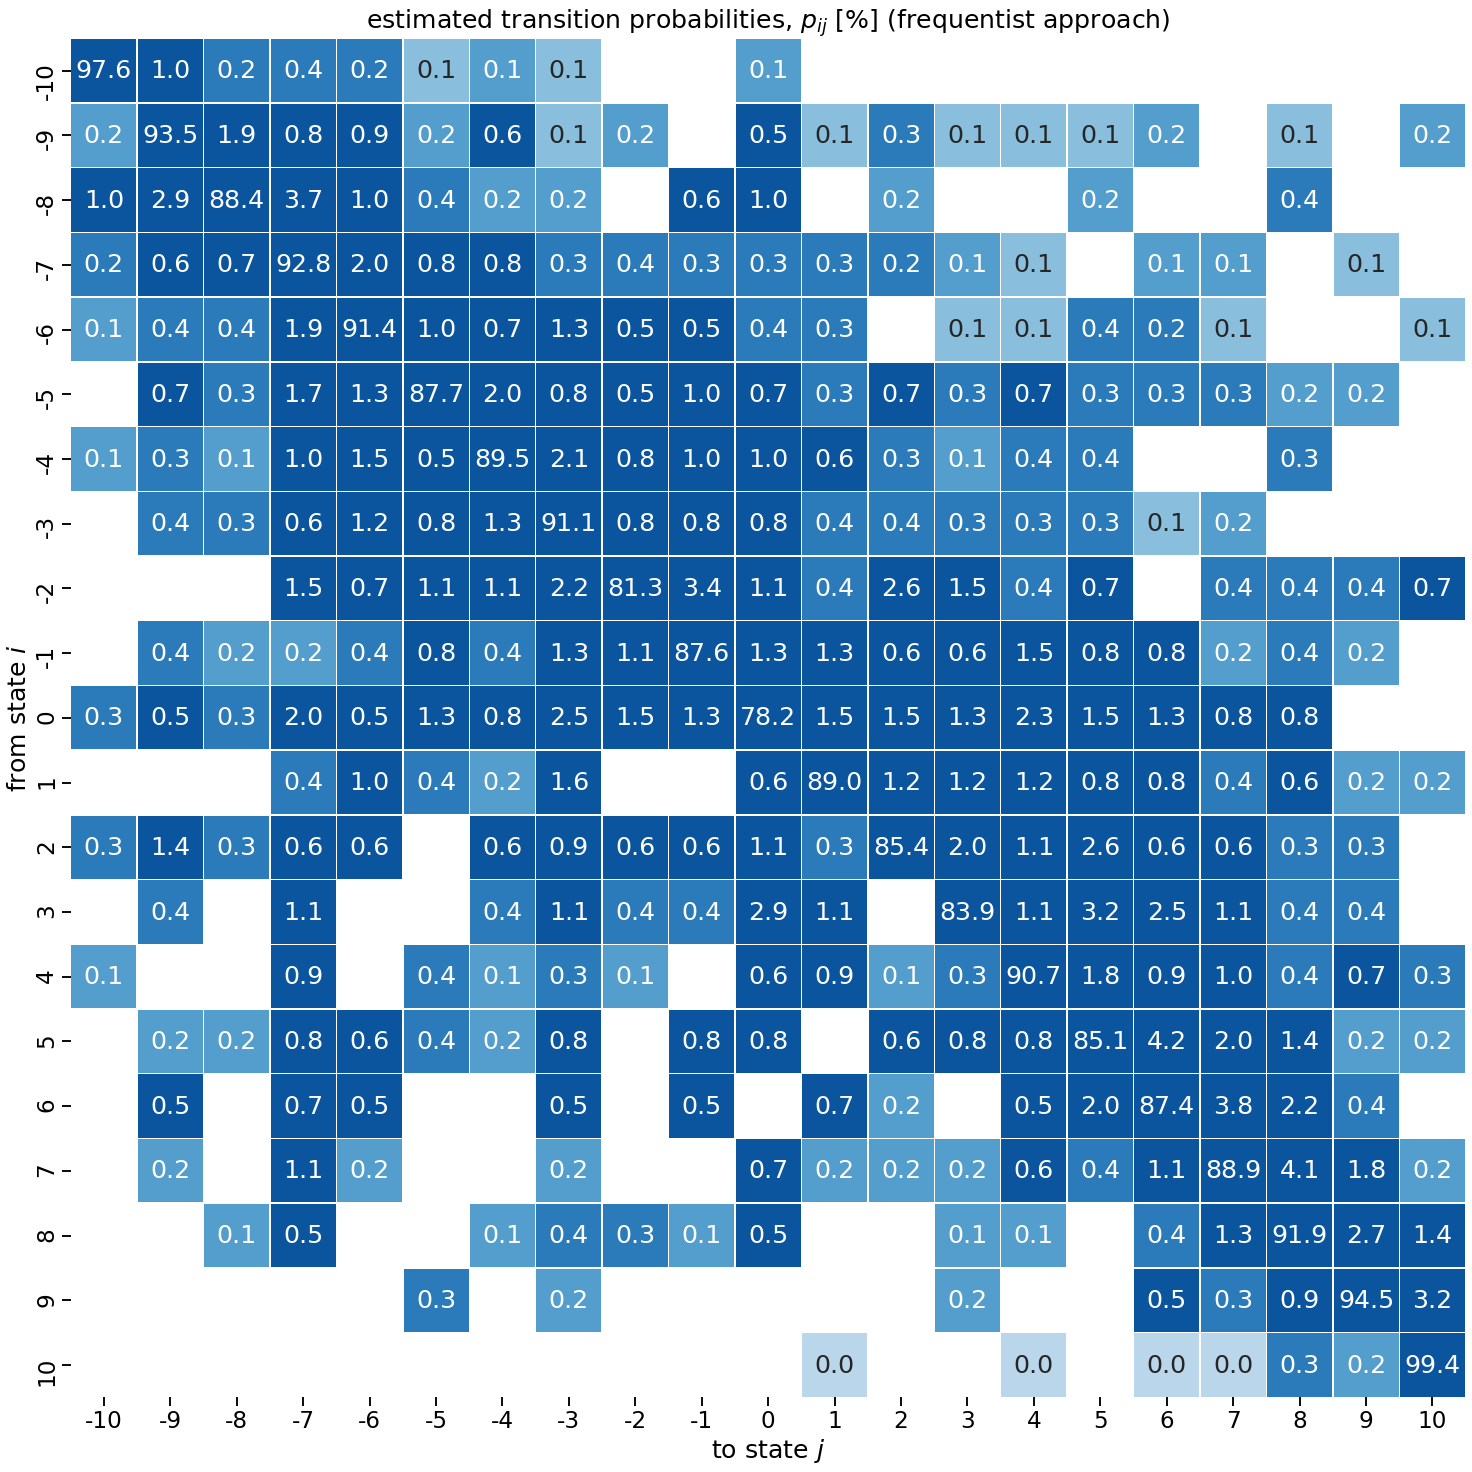

In [7]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries.min()+0.01, vmax=P_allCountries.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$] (frequentist approach)')
plt.savefig('./../results/supplementaryFigures/FigS1-estimatedTransitionProbabilitiesFrequentist.pdf')

### Bayesian approach

In [8]:
P_allCountries_Bayes = estimateTransitionMatrix(timeSeries,approach='bayesian')


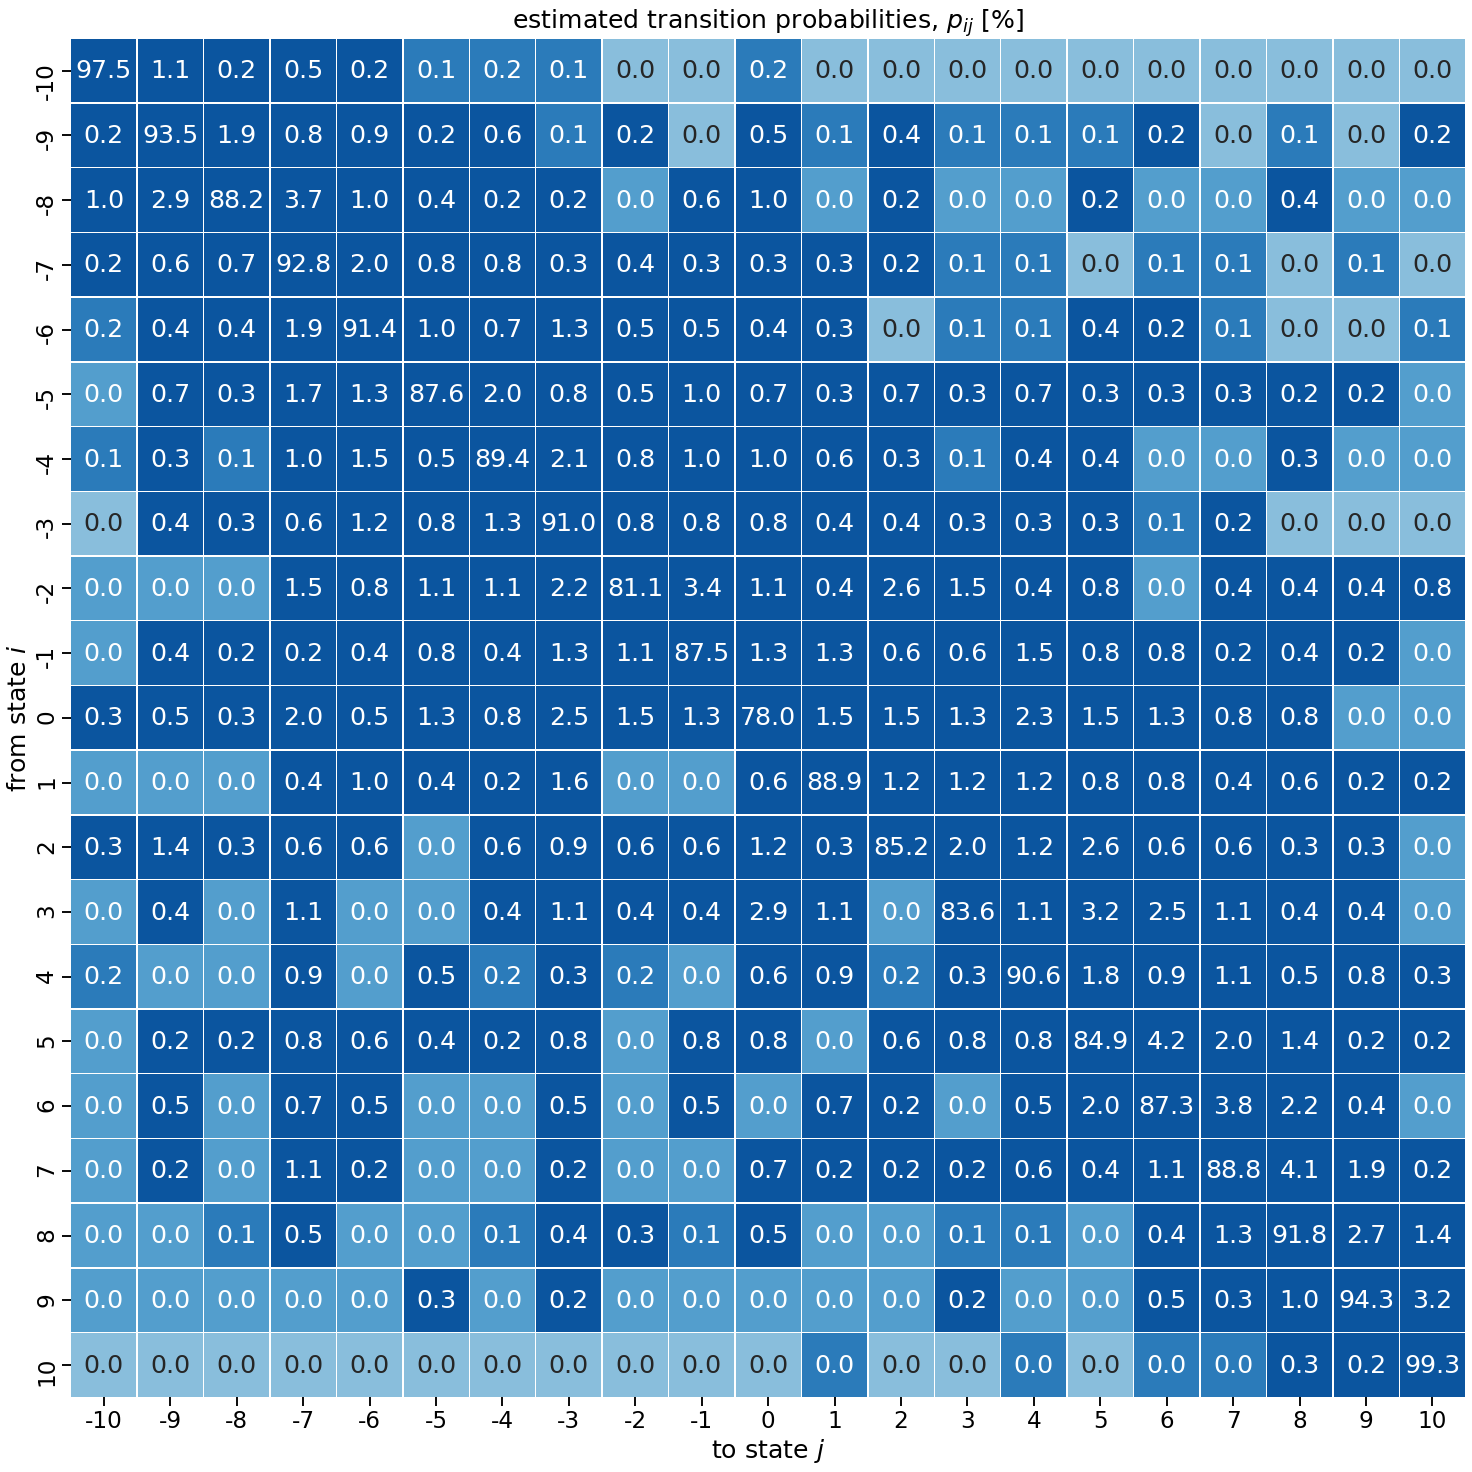

In [9]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Bayes*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Bayes.min(), vmax=P_allCountries_Bayes.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$]')
plt.savefig('./../results/figures/Fig2-estimatedTransitionProbabilities.pdf')

In [10]:
np.savetxt('./../results/transitionBayesAllCountries.csv',P_allCountries_Bayes)

## Testing

To further test our Bayesian estimation approach, we sample time series from the estimated Markov Model and investigate whether we estimate the same transition matrix from these sampled time series.

In [11]:
def simulateRegimeChangeTimeSeries(transitionMatrix, numberCountries,numberSteps):
    # simulate a number of regime time series from the estimated transition matrix

    simulatedData = pd.DataFrame()
    for c in np.arange(numberCountries):
        startingCondition = random.randint(0,20)
        simulatedChainRegime = simulateMarkovChain(transitionMatrix,startingCondition,nSteps=numberSteps)


        countryName = 'example country ' + str(c)
        simulatedDataThis = pd.DataFrame()
        
        simulatedDataThis['year'] = np.arange(numberSteps+1)
        simulatedDataThis['polity2'] = np.array(simulatedChainRegime) -10
        simulatedDataThis['country'] = countryName
        # concatenate to output DF
        simulatedData=pd.concat([simulatedData,simulatedDataThis])

    return(simulatedData)



In [12]:
simulatedTimeSeries = simulateRegimeChangeTimeSeries(P_allCountries_Bayes, 1000,500)

In [13]:
P_allCountries_Bayes_EstimatedFromSampled = estimateTransitionMatrix(simulatedTimeSeries,approach='bayesian')


Text(0.5, 1.0, 'estimated transition probabilities, $p_{ij}$ [$\\%$]')

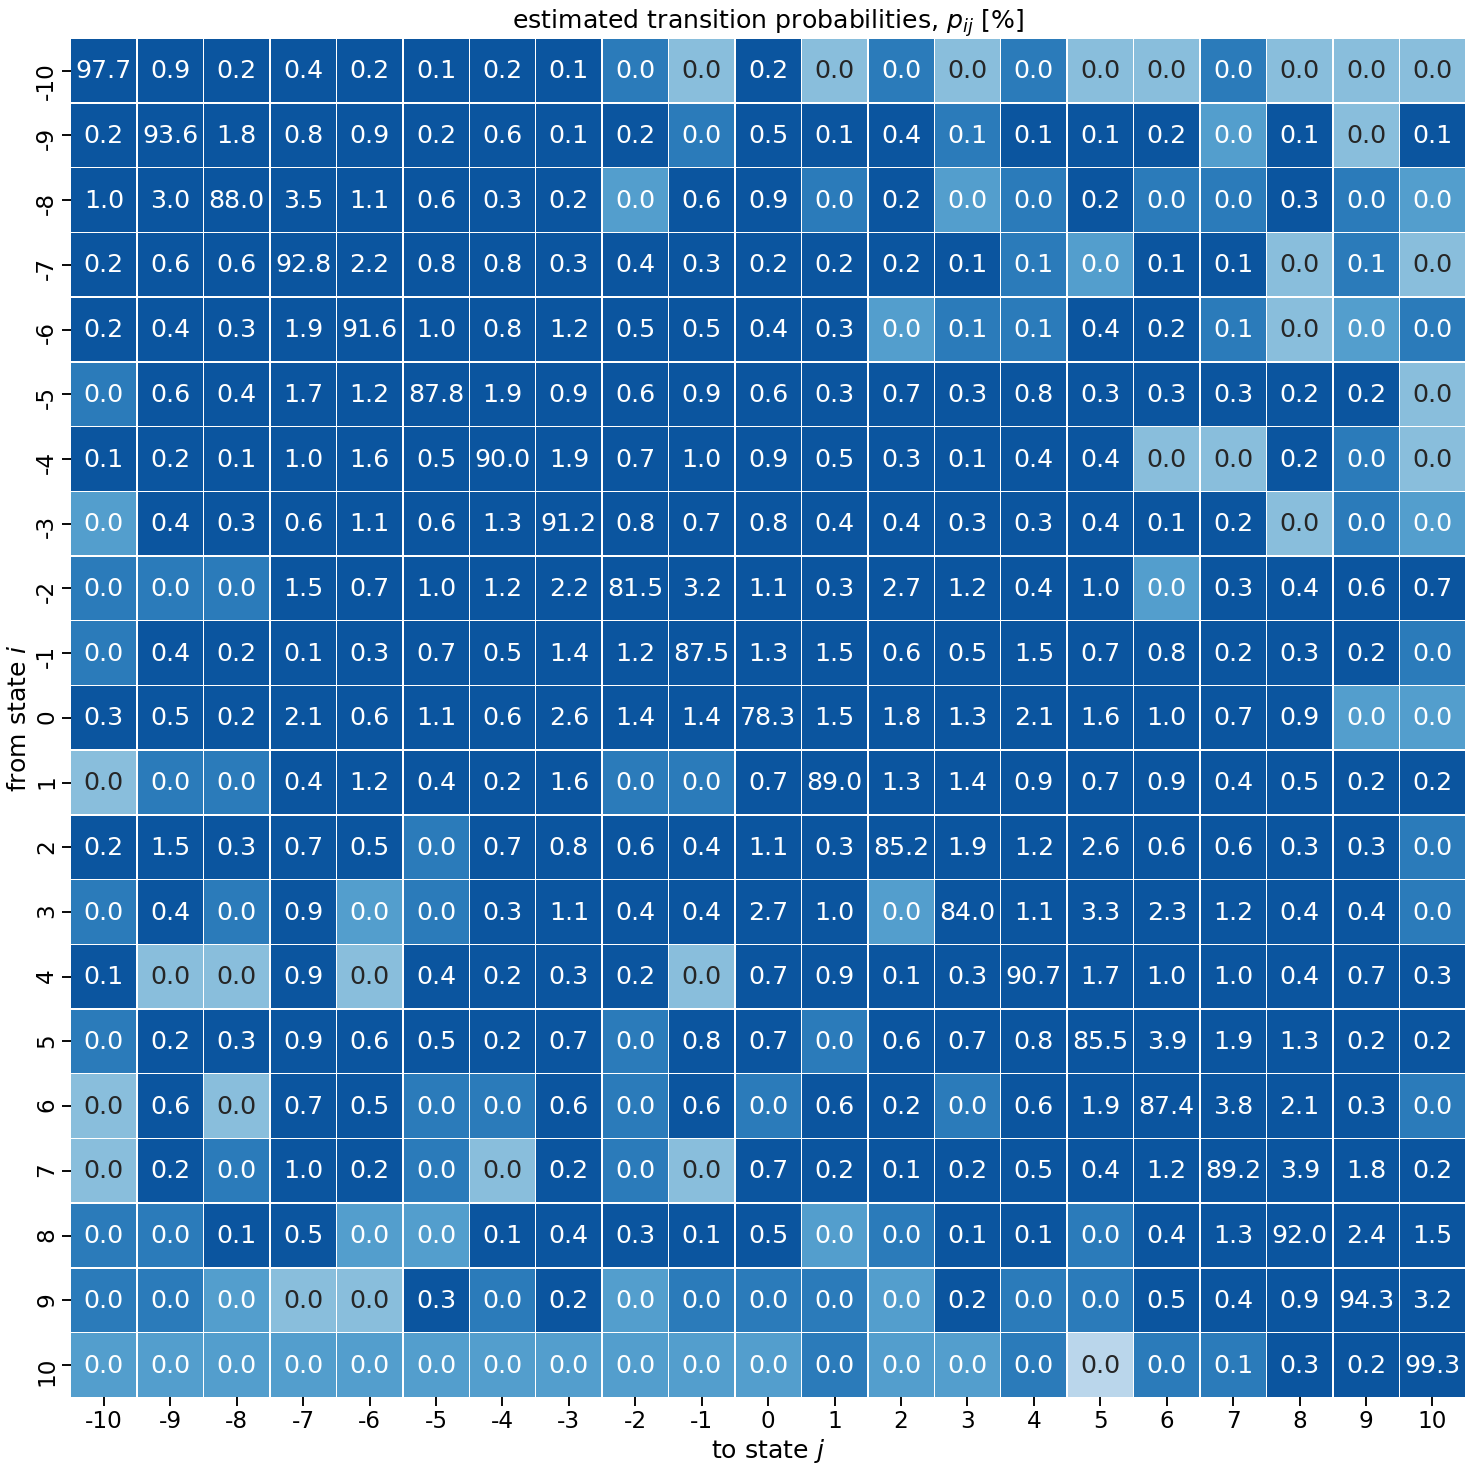

In [14]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Bayes_EstimatedFromSampled*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Bayes_EstimatedFromSampled.min(), vmax=P_allCountries_Bayes_EstimatedFromSampled.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$]')


In [15]:
# We find the same expected change as in the original transition matrix
np.mean(P_allCountries_Bayes_EstimatedFromSampled)

0.04761904761904764

To confirm that the re-estimated transition matrix closely resembled the original one, we visualise the estimation error and see that it is below a percentage for all transitions.

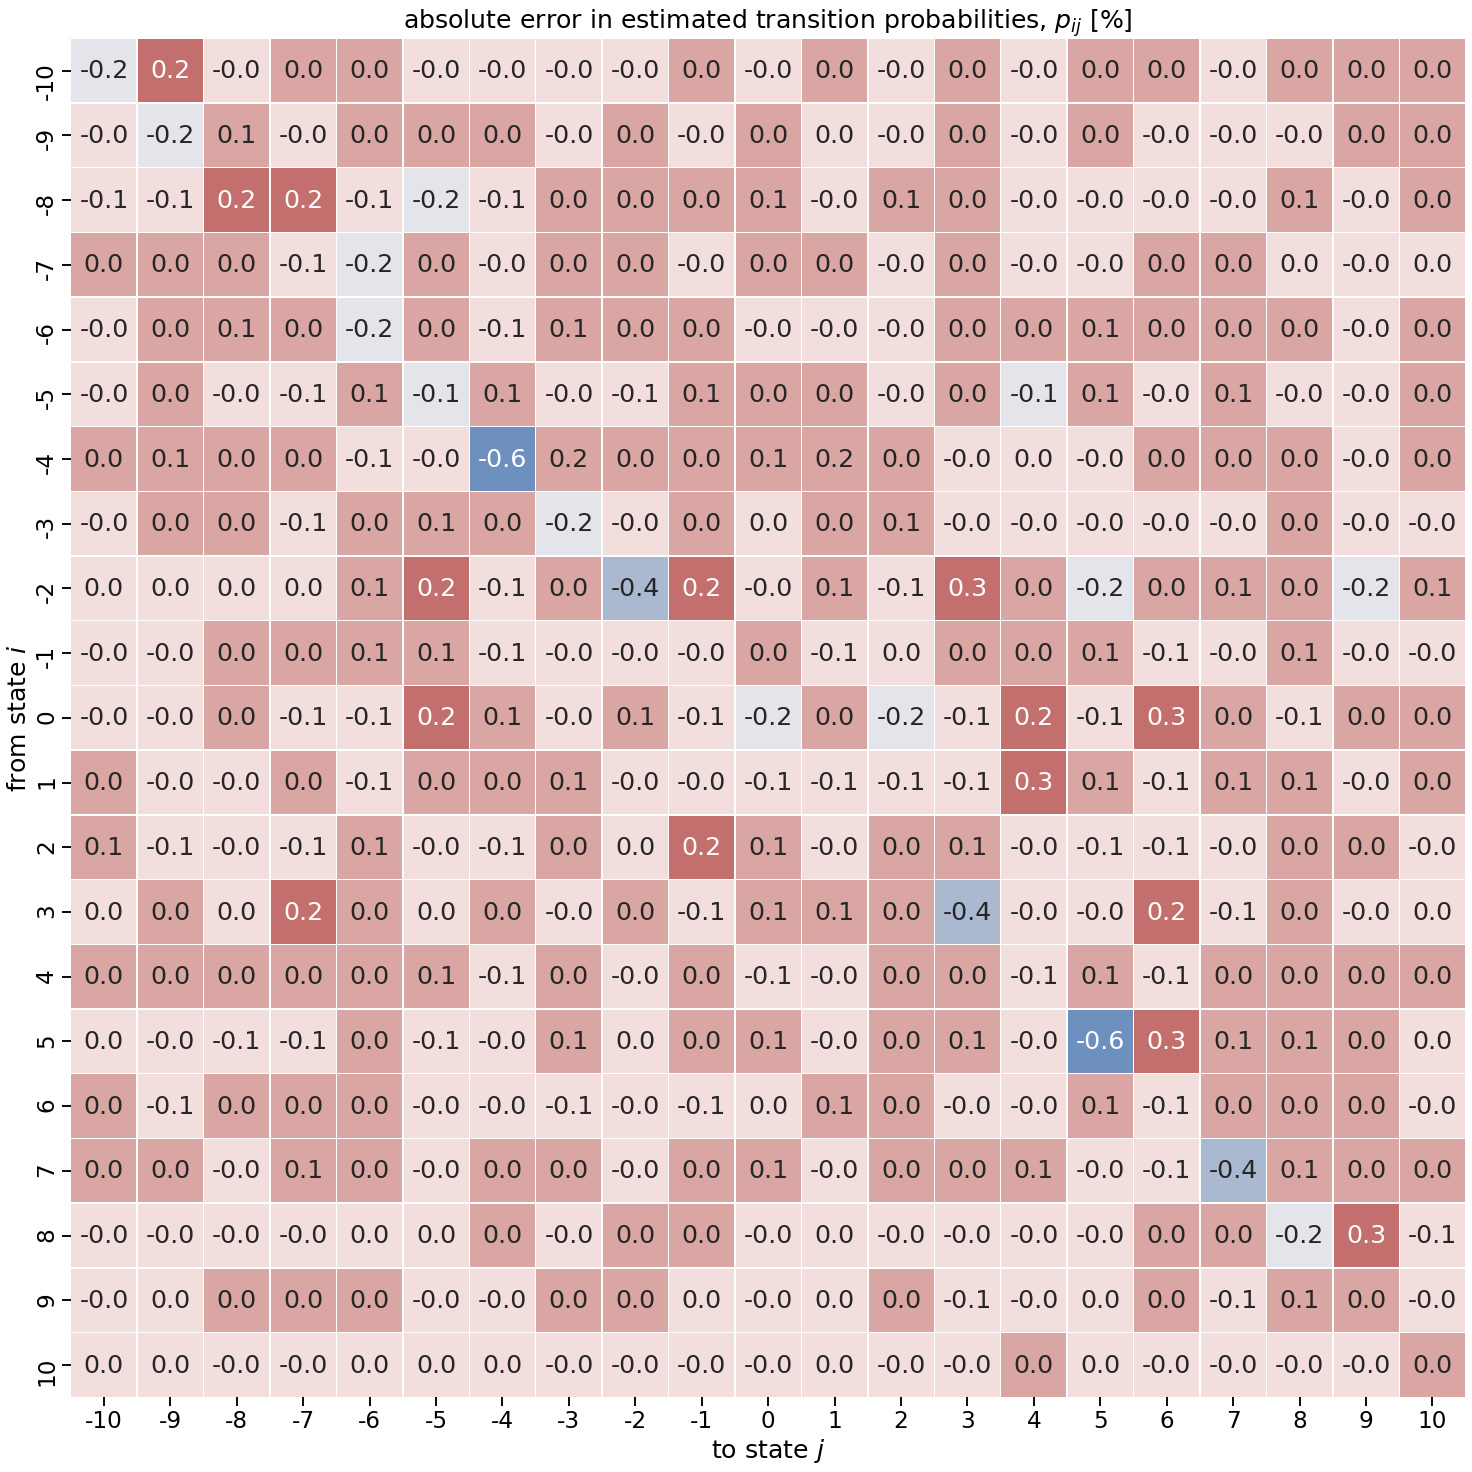

In [16]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap((P_allCountries_Bayes-P_allCountries_Bayes_EstimatedFromSampled)*100, annot=True,fmt="1.1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidths=.5,cmap=sns.color_palette("vlag"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'absolute error in estimated transition probabilities, $p_{ij}$ [$\%$]')
plt.savefig('./../results/supplementaryFigures/FigS2-errorEstimationTransitionProbabilities.pdf')


## Compute the expected Change

In [17]:
# check for each state the expected change
# 1) create the change matrix

deltaS=np.zeros((21,21))
for K in np.arange(-20,21,1):
    deltaS = deltaS + K*np.eye(N=21,M=21,k=K)

    
weightedDeltaS = np.multiply(P_allCountries_Bayes,deltaS)
#
meanDeltaS = np.sum(weightedDeltaS,axis=1)


# absolute value
deltaSAbs=np.zeros((21,21))
for K in np.arange(-20,21,1):
    deltaSAbs = deltaSAbs + np.sign(K)*K*np.eye(N=21,M=21,k=K)
    
weightedDeltaSAbs = np.multiply(P_allCountries_Bayes,deltaSAbs)    
    
meanDeltaSAbs = np.sum(weightedDeltaSAbs,axis=1)

In [24]:
# least square fit of sinus curve to data
from scipy.optimize import curve_fit

x=np.arange(-10,11,1)

def sinusFunction(x, a,b):
    return a * np.sin(2*np.pi*x/21-b)

param, param_cov = curve_fit(sinusFunction, x, meanDeltaS)
y = sinusFunction(x,param[0],param[1])

def cosineFunction(x, a,b):
    return a * np.cos(np.pi*x/21-b)


param2, param_cov2 = curve_fit(cosineFunction, x, meanDeltaSAbs)
y2 = cosineFunction(x,param2[0],param2[1])


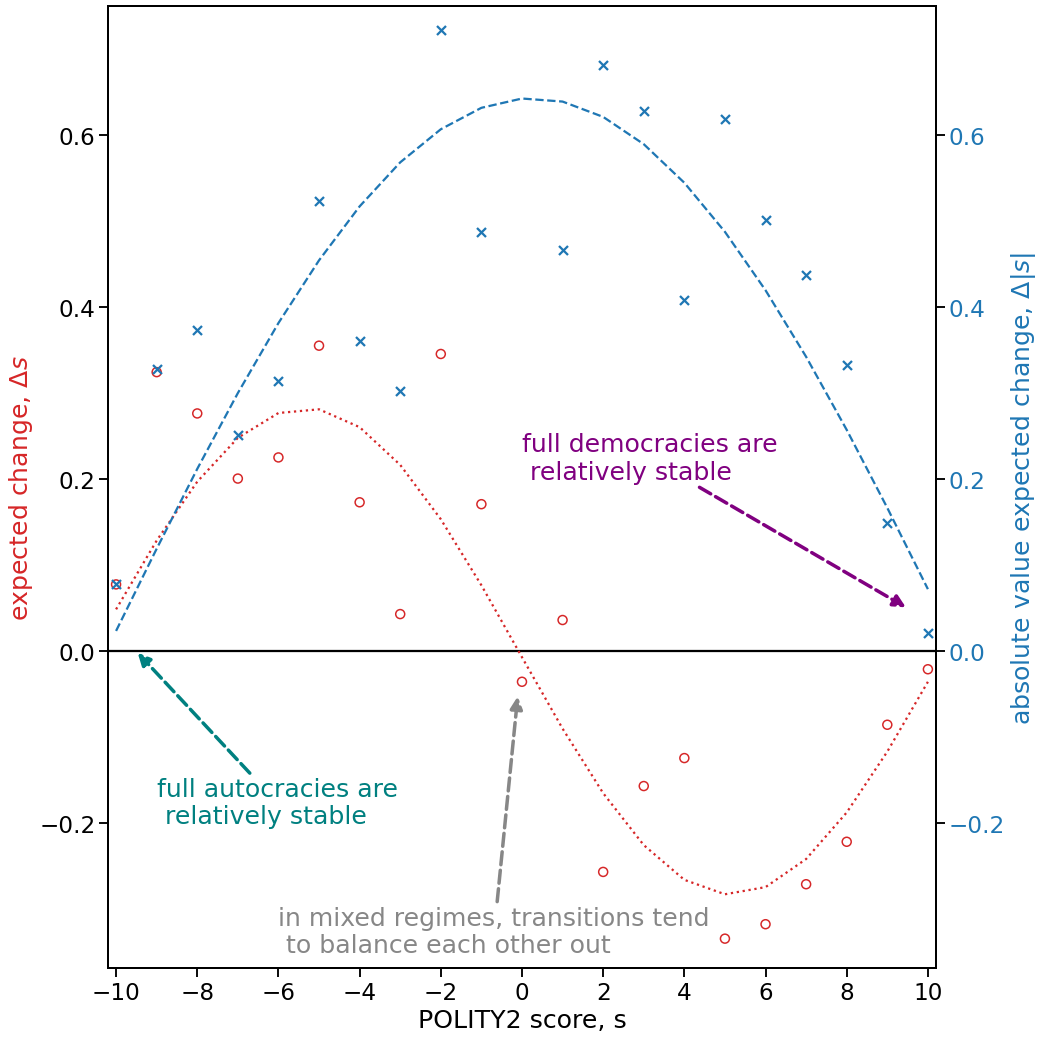

In [25]:
# colors for plotting
teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()

# plotting
fig, ax1 = plt.subplots(figsize=(15,15))
color1 = 'tab:red'
ax1.set_ylabel('sin', color=color1)  # we already handled the x-label with ax1
plt.scatter(np.arange(-10,11,1),meanDeltaS,color=color1,marker='o', facecolors='none')
# plot fit line
plt.plot(x,y,color=color1,linestyle=':')



plt.ylabel(r'expected change, $\Delta s$')
plt.hlines(y=0,xmin=-11,xmax=11,linestyles='solid',color='k')
plt.xlabel('POLITY2 score, s')

plt.xlim([-10.2,10.2])
plt.xticks(np.arange(-10,11,2))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('sin', color=color2)  # we already handled the x-label with ax1
ax2.scatter(np.arange(-10,11,1),meanDeltaSAbs,color=color2,marker='x')
plt.plot(x,y2,color=color2,linestyle='--')




ax2.tick_params(axis='y', labelcolor=color2)
# set the axes to same limits
ax2.set_ylim(ax1.get_ylim()[0],0.75)
ax1.set_ylim(ax1.get_ylim()[0],0.75)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.ylabel(r'absolute value expected change, $\Delta |s|$')

# add arrows to highlight
teal = [0,0.5,0.5]
lightgray = [0.53,0.53,0.53]
purple = [0.5,0.0,0.5]

ax1.annotate('full autocracies are\n relatively stable', xy=(-9.5, -0.00),
             xycoords='data',
             xytext=(-9, -0.2),
             textcoords='data',
             color=teal,
             arrowprops=dict(arrowstyle= '-|>',
                             color=teal,
                             lw=3.5,
                             ls='--')
           )

ax1.annotate('full democracies are\n relatively stable', xy=(9.5, 0.05),
             xycoords='data',
             xytext=(0, 0.2),
             textcoords='data',
             color=purple,
             arrowprops=dict(arrowstyle= '-|>',
                             color=purple,
                             lw=3.5,
                             ls='--')
           )

ax1.annotate('in mixed regimes, transitions tend\n to balance each other out', xy=(-0.1, -0.05),
             xycoords='data',
             xytext=(-6, -0.35),
             textcoords='data',
             color=lightgray,
             arrowprops=dict(arrowstyle= '-|>',
                             color=lightgray,
                             lw=3.5,
                             ls='--')
           )

#plt.savefig('./figures/expectedDeltasWithAbs.pdf')
plt.savefig('./../results/figures/Fig3-expectedDeltasWithAbs.pdf')